In [77]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from copy import deepcopy
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydot_ng

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [78]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline
import numpy as np
from googleapiclient.discovery import build

Populating the interactive namespace from numpy and matplotlib


In [79]:
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
intakes = pd.read_csv('/content/drive/MyDrive/Austin_Animal_Center_Intakes.csv')
intakes.columns = ['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found_Location',
       'Intake_Type', 'IntakeCondition', 'Animal_Type', 'Sex',
       'Age', 'Breed', 'Color']

outcomes = pd.read_csv('/content/drive/MyDrive/Austin_Animal_Center_Outcomes.csv')
outcomes.columns = ['Animal ID', 'Name', 'DateTime', 'MonthYear', 'DOB',
       'Outcome_Type', 'Outcome_Subtype', 'Animal_Type',
       'Sex_upon_Outcome', 'Age_upon_Outcome', 'Breed', 'Color']

In [81]:
print ("How many intakes and outcomes do we have?")
print (len(intakes), "intakes")
print (len(outcomes), "outcomes")
print ("What are the columns?")
print ("INTAKE: ",intakes.columns)
print ("OUTCOMES: ",outcomes.columns)

How many intakes and outcomes do we have?
63328 intakes
63643 outcomes
What are the columns?
INTAKE:  Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found_Location',
       'Intake_Type', 'IntakeCondition', 'Animal_Type', 'Sex', 'Age', 'Breed',
       'Color'],
      dtype='object')
OUTCOMES:  Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'DOB', 'Outcome_Type',
       'Outcome_Subtype', 'Animal_Type', 'Sex_upon_Outcome',
       'Age_upon_Outcome', 'Breed', 'Color'],
      dtype='object')


In [82]:
# Create a new dataframe from the inner join between intakes and outcomes
records = intakes.merge(outcomes, how='inner', left_on = 'Animal ID', right_on = 'Animal ID', suffixes=('_intake', '_outcome'))
print ("Resulting dataframe has", len(records), "records")

Resulting dataframe has 76977 records


DATA CLEANING OF THE DATASET

In [83]:
print ("Null DOBS:", len(records[records['DOB'].isnull()]))
print ("Date of birth appears to be irrelevant because every animal has a DOB even though not all animals were born in the shelter")
del records['DOB']
del records['Animal_Type_outcome']
del records['Breed_outcome']
del records['Color_outcome']
print ("Animal Type, Breed and Color are all consistent across intake and outake.")

print ("COLUMNS: ", records.columns)

Null DOBS: 0
Date of birth appears to be irrelevant because every animal has a DOB even though not all animals were born in the shelter
Animal Type, Breed and Color are all consistent across intake and outake.
COLUMNS:  Index(['Animal ID', 'Name_intake', 'DateTime_intake', 'MonthYear_intake',
       'Found_Location', 'Intake_Type', 'IntakeCondition',
       'Animal_Type_intake', 'Sex', 'Age', 'Breed_intake', 'Color_intake',
       'Name_outcome', 'DateTime_outcome', 'MonthYear_outcome', 'Outcome_Type',
       'Outcome_Subtype', 'Sex_upon_Outcome', 'Age_upon_Outcome'],
      dtype='object')


REQUIRED FEATURE EXTRACTION

In [84]:
def get_gender(val):
    try:
        val_list = val.split(' ')
        return val_list[1]
    except:
        return np.nan
def get_fixed(val):
    try:
        val_list = val.split(' ')
        return val_list[0]
    except:
        return np.nan

records['Gender'] = records['Sex'].apply(get_gender)
records['fixed_intake'] = records['Sex'].apply(get_fixed)
records['fixed_outcome'] = records['Sex_upon_Outcome'].apply(get_fixed)

records['fixed_changed'] = 0
mask = (records['fixed_intake'] == "Intact") & (records['fixed_outcome'] != "Intact")
records.loc[mask, 'fixed_changed'] = 1
mask = (records['fixed_intake'] != "Intact") & (records['fixed_outcome'] == "Intact")
records.loc[mask, 'fixed_changed'] = -1

records['fixed_changed'].value_counts()

fixed_changed
 0    49696
 1    27141
-1      140
Name: count, dtype: int64

In [85]:
import re

def get_age_bucket(val):
    if re.search("day", val):
        return "Less than 1 week"
    elif re.search("week", val):
        return "1-6 weeks"
    elif re.search("[1,2,3,4,5,6] month", val):
        return "1-6 months"
    elif re.search("[7,8,9,10,11,12] month", val):
        return "7-12 months"
    elif re.search("[1,2,3] year", val):
        return "1-3 years"
    elif re.search("[4,5,6] year", val):
        return "4-6 years"
    elif re.search("year", val):
        return "7+ years"
    else:
        return "other"

records['Age_Bucket'] = records['Age'].apply(get_age_bucket)
records['Age_Bucket'].value_counts()

Age_Bucket
1-3 years           33474
1-6 months          17315
4-6 years            8758
1-6 weeks            6522
7+ years             5570
7-12 months          4118
Less than 1 week     1220
Name: count, dtype: int64

In [86]:
def get_breed(val, type):
    val = val.lower()
    if re.search(type,val):
        return 1
    else:
        return 0

types = ['retriever','shepherd','beagle','terrier','boxer','poodle','rottweiler','dachshund','chihuahua','pit_bull']
for t in types:
    records[t] = records['Breed_intake'].apply(get_breed, args=(t,))

In [87]:
records['DateTime_intake'] = pd.to_datetime(records['DateTime_intake'])
records['DateTime_outcome'] = pd.to_datetime(records['DateTime_outcome'])
records['DateTime_length'] = records['DateTime_outcome'] - records['DateTime_intake']

def get_days_length(val):
    val = str(val)
    days = re.findall('\d*',val)[0]
    try:
        days = int(days)
        if days <= 7:
            return "0-7 days"
        elif days <= 21:
            return "1-3 weeks"
        elif days <= 42:
            return "3-6 weeks"
        elif days <= 84:
            return "7-12 weeks"
        elif days <= 168:
            return "12 weeks - 6 months"
        elif days <= 365:
            return "6-12 months"
        elif days <= 730:
            return "1-2 years"
        else:
            return "2+ years"
    except:
        return np.nan

records['Days_length'] = records['DateTime_length'].apply(get_days_length)
records['Days_length'].value_counts()

Days_length
0-7 days               40144
1-3 weeks              11795
3-6 weeks               5930
7-12 weeks              5380
12 weeks - 6 months     2895
6-12 months             2064
1-2 years               1042
2+ years                 327
Name: count, dtype: int64

In [88]:
records.to_csv("all_records_with_features.csv")

In [89]:
mask = (records['Intake_Type'] == "Euthanasia Request") & (records['Outcome_Type'] != "Euthanasia")
print (len(records[mask]), "animals")

77 animals


In [90]:
mask = (records['Sex'] != records['Sex_upon_Outcome']) & ((records['Sex_upon_Outcome'] != "Spayed Female") & (records['Sex_upon_Outcome'] != "Neutered Male"))
print (len(records[mask]), "animals were un-neutered/spayed during their time")

144 animals were un-neutered/spayed during their time


In [91]:
mask = (records['Sex'] != records['Sex_upon_Outcome']) & ((records['Sex_upon_Outcome'] == "Spayed Female") | (records['Sex_upon_Outcome'] == "Neutered Male"))
print (len(records[mask]), "animals were neutered/spayed during their time")

27139 animals were neutered/spayed during their time


<Axes: title={'center': 'Distribution of intake condition'}, xlabel='IntakeCondition'>

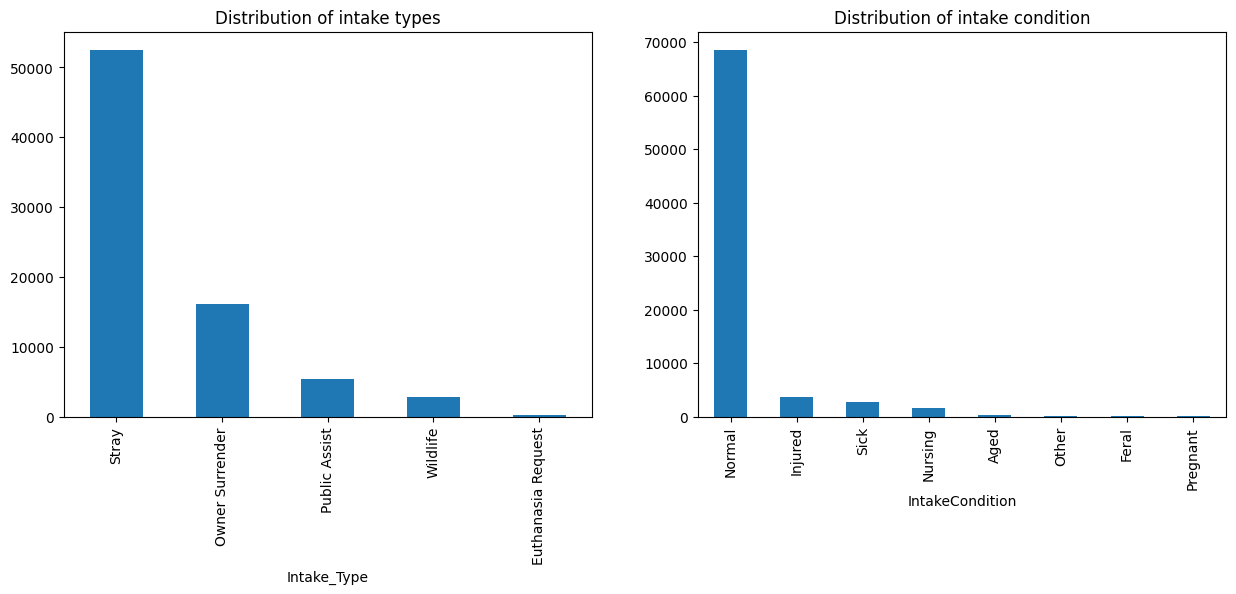

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2)
records['Intake_Type'].value_counts().plot(kind='bar', ax=axes[0], figsize=(15,5), title = "Distribution of intake types")
records['IntakeCondition'].value_counts().plot(kind='bar', ax=axes[1], figsize=(15,5), title = "Distribution of intake condition")

In [93]:
print ("TOTAL: ", len(records))
print (records['Intake_Type'].value_counts())
print (records['IntakeCondition'].value_counts())

TOTAL:  76977
Intake_Type
Stray                 52498
Owner Surrender       16123
Public Assist          5313
Wildlife               2773
Euthanasia Request      270
Name: count, dtype: int64
IntakeCondition
Normal      68527
Injured      3581
Sick         2704
Nursing      1602
Aged          305
Other         132
Feral          78
Pregnant       48
Name: count, dtype: int64


In [94]:
intake_gb = records.groupby(['Intake_Type','Outcome_Type'])['Outcome_Type'].count().unstack()
intake_gb = intake_gb.T

def get_perc(val,col):
    return val / intake_gb[col].sum() * 100

intake_gb_perc = pd.DataFrame()
for col in intake_gb.columns:
    intake_gb_perc[col] = intake_gb[col].apply(get_perc, args=(col,))

intake_gb_perc

,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife
Outcome_Type,,,,,
Adoption,8.148148,62.854308,14.323358,40.934547,0.072254
Died,1.111111,0.440365,0.357613,0.718150,2.998555
Disposal,NaN,0.012405,0.451722,0.049528,7.406069
Euthanasia,71.481481,3.677976,5.383023,3.745047,87.861272
Missing,NaN,0.043416,0.075287,0.074291,0.036127
Relocate,NaN,NaN,NaN,0.005715,0.361272
Return to Owner,6.296296,8.242883,66.610201,23.828482,0.072254
Rto-Adopt,NaN,0.031012,NaN,0.034288,NaN
Transfer,12.962963,24.697637,12.798795,30.609951,1.192197


In [95]:
# What are the top two outcomes by intake type?
def find_top_two_outcomes(col):
    col = col.sort_values(ascending=False)
    print (col[:2])

for col in intake_gb_perc.columns:
    find_top_two_outcomes(intake_gb_perc[col])

Outcome_Type
Euthanasia    71.481481
Transfer      12.962963
Name: Euthanasia Request, dtype: float64
Outcome_Type
Adoption    62.854308
Transfer    24.697637
Name: Owner Surrender, dtype: float64
Outcome_Type
Return to Owner    66.610201
Adoption           14.323358
Name: Public Assist, dtype: float64
Outcome_Type
Adoption    40.934547
Transfer    30.609951
Name: Stray, dtype: float64
Outcome_Type
Euthanasia    87.861272
Disposal       7.406069
Name: Wildlife, dtype: float64


Median 4 days 22:11:00 -- true average stay
Mean 15 days 02:57:04.824817802 -- mean is skewed by animals with long stays
Mode 0   0 days 00:14:00
Name: DateTime_length, dtype: timedelta64[ns] -- most likely transfered


<Axes: title={'center': 'Length of Stay'}, xlabel='Days_length'>

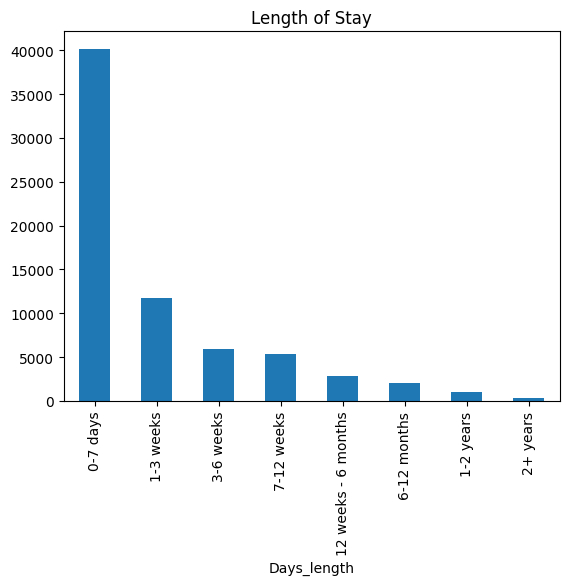

In [96]:
print ("Median", records["DateTime_length"].median(), "-- true average stay")
print ("Mean", records["DateTime_length"].mean(), "-- mean is skewed by animals with long stays")
print ("Mode", records["DateTime_length"].mode(), "-- most likely transfered")
records['Days_length'].value_counts().plot(kind="bar", title = "Length of Stay")

In [97]:
records['Animal_Type_intake'].value_counts()

Animal_Type_intake
Dog          48097
Cat          25125
Other         3493
Bird           254
Livestock        8
Name: count, dtype: int64

<Axes: title={'center': 'Length of stay for Birds'}, xlabel='Days_length'>

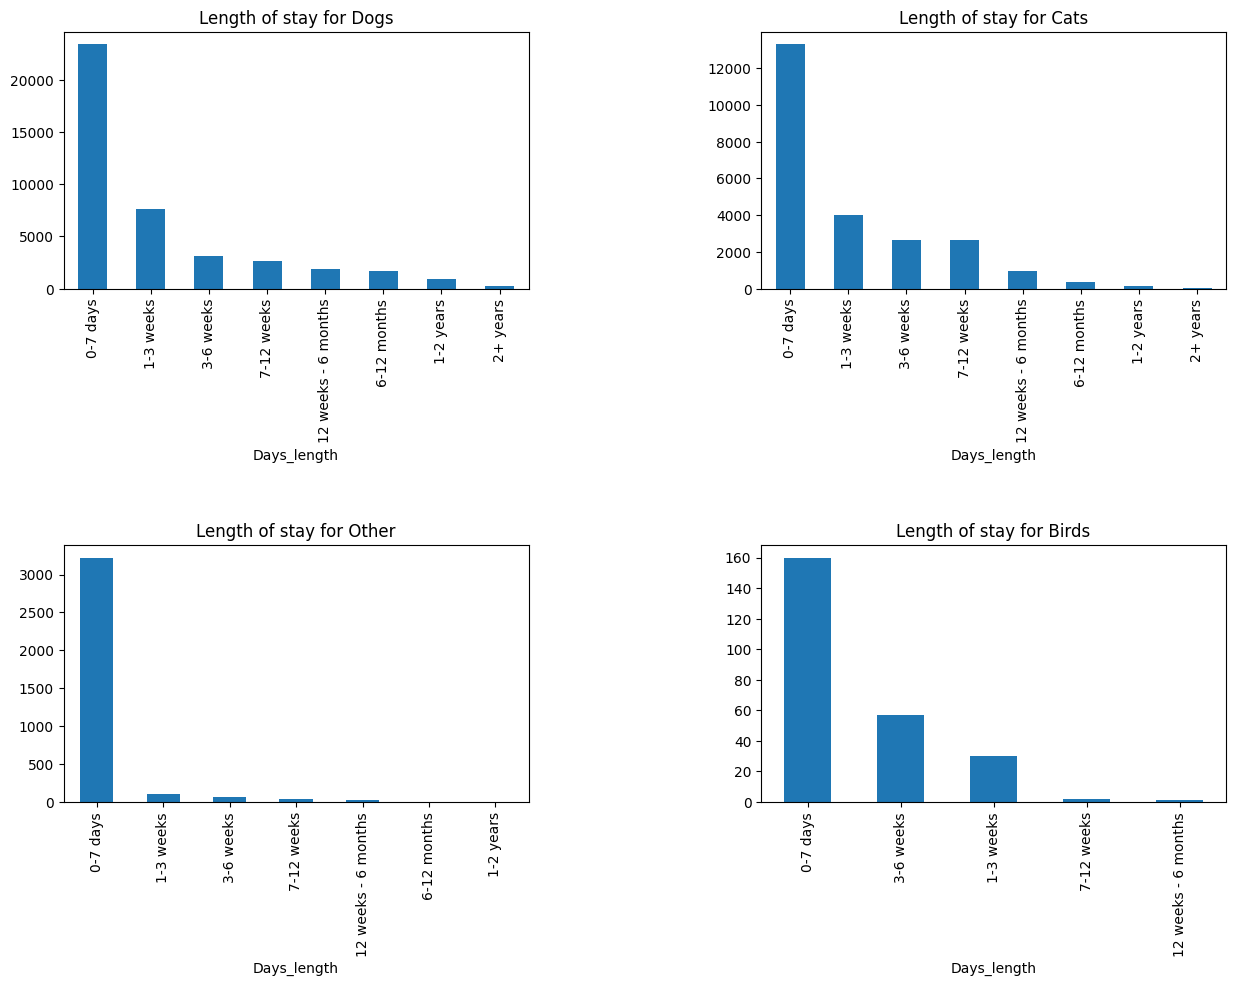

In [98]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=1, wspace = .5)

records[records["Animal_Type_intake"] == "Dog"]['Days_length'].value_counts().plot(kind='bar',ax=axes[0,0], figsize=(15,10), title = "Length of stay for Dogs")
records[records["Animal_Type_intake"] == "Cat"]['Days_length'].value_counts().plot(kind='bar',ax=axes[0,1], figsize=(15,10), title = "Length of stay for Cats")
records[records["Animal_Type_intake"] == "Other"]['Days_length'].value_counts().plot(kind='bar',ax=axes[1,0], figsize=(15,10), title = "Length of stay for Other")
records[records["Animal_Type_intake"] == "Bird"]['Days_length'].value_counts().plot(kind='bar',ax=axes[1,1], figsize=(15,10), title = "Length of stay for Birds")

In [99]:
from scipy.stats import ttest_ind

dog_records = records[records["Animal_Type_intake"] == "Dog"]
cat_records = records[records["Animal_Type_intake"] == "Cat"]

print ("Dog Mean: ", dog_records["DateTime_length"].mean())
print ("Dog Median: ", dog_records["DateTime_length"].median())
print ("Cat Mean: ", cat_records["DateTime_length"].mean())
print ("Cat Median: ", cat_records["DateTime_length"].median())
dog_records["DateTime_length"] = pd.to_timedelta(dog_records["DateTime_length"]).astype("int64") / 1e9
cat_records["DateTime_length"] = pd.to_timedelta(cat_records["DateTime_length"]).astype("int64") / 1e9

# Run the t-test again
print(ttest_ind(dog_records["DateTime_length"], cat_records["DateTime_length"]))

Dog Mean:  14 days 01:51:08.355614695
Dog Median:  5 days 01:14:00
Cat Mean:  18 days 18:45:55.140298507
Cat Median:  5 days 05:26:00
TtestResult(statistic=-4.482424288975616, pvalue=7.391156291734724e-06, df=73220.0)


<ipython-input-99-3c5791f38bef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dog_records["DateTime_length"] = pd.to_timedelta(dog_records["DateTime_length"]).astype("int64") / 1e9
<ipython-input-99-3c5791f38bef>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_records["DateTime_length"] = pd.to_timedelta(cat_records["DateTime_length"]).astype("int64") / 1e9


In [100]:
print ("DOGS")
dog_records_outcome_gb = dog_records.groupby(['Outcome_Type'])['Outcome_Type'].count()
print (float(dog_records_outcome_gb["Adoption"]) / float(dog_records_outcome_gb.sum()) * 100, "% adopted")
print (float(dog_records_outcome_gb["Euthanasia"]) / float(dog_records_outcome_gb.sum()) * 100, "% euthanized")
print (float(dog_records_outcome_gb["Return to Owner"]) / float(dog_records_outcome_gb.sum()) * 100, "% return to owner")
print (float(dog_records_outcome_gb["Transfer"]) / float(dog_records_outcome_gb.sum()) * 100, "% transferred")

print ("\nCATS")
cat_records_outcome_gb = cat_records.groupby(['Outcome_Type'])['Outcome_Type'].count()
print (float(cat_records_outcome_gb["Adoption"]) / float(cat_records_outcome_gb.sum()) * 100, "% adopted")
print (float(cat_records_outcome_gb["Euthanasia"]) / float(cat_records_outcome_gb.sum()) * 100, "% euthanized")
print (float(cat_records_outcome_gb["Return to Owner"]) / float(cat_records_outcome_gb.sum()) * 100, "% return to owner")
print (float(cat_records_outcome_gb["Transfer"]) / float(cat_records_outcome_gb.sum()) * 100, "% transferred")

DOGS
44.68147039254824 % adopted
3.33291749833666 % euthanized
33.308383233532936 % return to owner
18.30921490352628 % transferred

CATS
42.572838719949054 % adopted
4.983282916733004 % euthanized
5.329565355835058 % return to owner
45.6774398981054 % transferred


In [101]:
print ("MALE DOGS")
male_dog_records_outcome_gb = dog_records[dog_records['Gender'] == "Male"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print (float(male_dog_records_outcome_gb["Adoption"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% adopted")
print (float(male_dog_records_outcome_gb["Euthanasia"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% euthanized")
print (float(male_dog_records_outcome_gb["Return to Owner"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% return to owner")
print (float(male_dog_records_outcome_gb["Transfer"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% transferred")

print ("\nFEMALE DOGS")
female_dog_records_outcome_gb = dog_records[dog_records['Gender'] == "Female"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print (float(female_dog_records_outcome_gb["Adoption"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% adopted")
print (float(female_dog_records_outcome_gb["Euthanasia"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% euthanized")
print (float(female_dog_records_outcome_gb["Return to Owner"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% return to owner")
print (float(female_dog_records_outcome_gb["Transfer"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% transferred")

print ("\nMALE CATS")
male_cat_records_outcome_gb = cat_records[cat_records['Gender'] == "Male"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print (float(male_cat_records_outcome_gb["Adoption"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% adopted")
print (float(male_cat_records_outcome_gb["Euthanasia"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% euthanized")
print (float(male_cat_records_outcome_gb["Return to Owner"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% return to owner")
print (float(male_cat_records_outcome_gb["Transfer"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% transferred")

print ("\nFEMALE CATS")
female_cat_records_outcome_gb = cat_records[cat_records['Gender'] == "Female"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print (float(female_cat_records_outcome_gb["Adoption"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% adopted")
print (float(female_cat_records_outcome_gb["Euthanasia"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% euthanized")
print (float(female_cat_records_outcome_gb["Return to Owner"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% return to owner")
print (float(female_cat_records_outcome_gb["Transfer"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% transferred")

MALE DOGS
42.25551808706315 % adopted
3.5905885959534025 % euthanized
36.078326180257505 % return to owner
17.73068669527897 % transferred

FEMALE DOGS
47.93165055659902 % adopted
2.9547849191442577 % euthanized
30.20294104173347 % return to owner
18.580787026432727 % transferred

MALE CATS
46.04878048780488 % adopted
5.348115299334812 % euthanized
6.740576496674058 % return to owner
40.390243902439025 % transferred

FEMALE CATS
47.51338283543429 % adopted
4.075289241927129 % euthanized
4.895527542738733 % return to owner
42.28975997237092 % transferred


<Axes: title={'center': 'Distribution of outcomes based on age (%)'}>

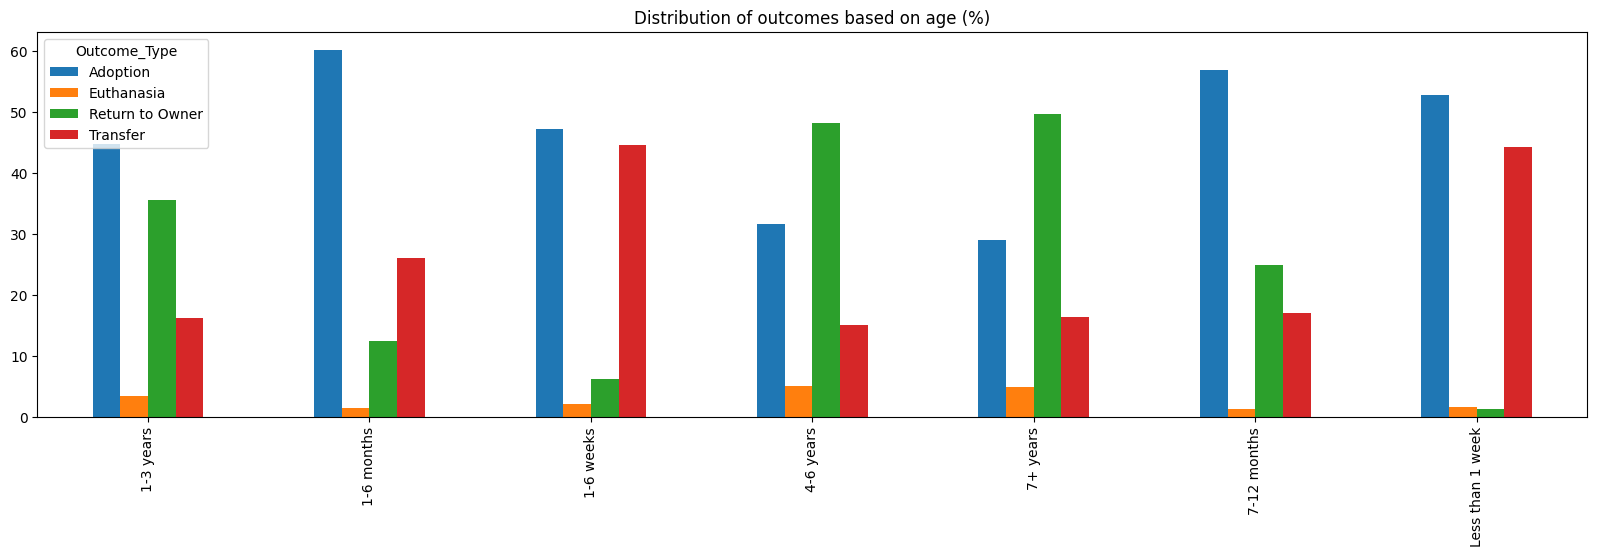

In [102]:
dog_records_outcome_age_gb = dog_records.groupby(['Outcome_Type','Age_Bucket'])['Age_Bucket'].count().unstack()
# Drop outcomes we're not interested in
dog_records_outcome_age_gb = dog_records_outcome_age_gb.drop(dog_records_outcome_age_gb.index[[1,2,4,6]])

# Transform into a percentage
def get_perc_outcome(val,col):
    return float(val) / float(dog_records_outcome_age_gb[col].sum()) * 100

perc_dog_records_outcome_age_gb = pd.DataFrame()
for col in dog_records_outcome_age_gb.columns:
    perc_dog_records_outcome_age_gb[col] = dog_records_outcome_age_gb[col].apply(get_perc_outcome, args=(col,))

perc_dog_records_outcome_age_gb = perc_dog_records_outcome_age_gb.T
perc_dog_records_outcome_age_gb.plot(kind="bar", figsize=(20,5), title = "Distribution of outcomes based on age (%)")

Adoption vs Other Outcomes

In [103]:
Have_name_start = "some_value"
Have_name_end = "some_value"

In [104]:
records.columns = ['Animal ID','Name_intake','DateTime_intake','MonthYear_intake','Found_Location','Intake_Type',\
                   'IntakeCondition','Animal_Type_intake','Sex','Age','Breed_intake','Color_intake','Name_outcome',\
                   'DateTime_outcome','MonthYear_outcome','Outcome_Type','Outcome_Subtype','Sex_upon_Outcome',\
                   'Age_upon_Outcome','Gender','fixed_intake','fixed_outcome','fixed_changed','Age_Bucket',\
                   'retriever','shepherd','beagle','terrier','boxer','poodle','rottweiler','dachshund',\
                   'chihuahua','pit_bull','DateTime_length','Days_length']

In [107]:
# Set the target column for prediction
records['Target'] = 0
adopt_mask = records['Outcome_Type'] == 'Adoption'
records.loc[adopt_mask, 'Target'] = 1
records

,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,Age,...,terrier,boxer,poodle,rottweiler,dachshund,chihuahua,pit_bull,DateTime_length,Days_length,Target
0,A730601,NaN,2016-07-07 12:11:00,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Cat,Intact Male,7 months,...,0,0,0,0,0,0,0,0 days 20:49:00,0-7 days,0
1,A683644,*Zoey,2014-07-13 11:02:00,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Dog,Intact Female,4 weeks,...,0,0,0,0,0,0,0,115 days 23:04:00,12 weeks - 6 months,1
2,A676515,Rico,2014-04-11 08:45:00,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Dog,Intact Male,2 months,...,0,0,0,0,0,0,0,3 days 09:53:00,0-7 days,0
3,A742953,NaN,2017-01-31 13:30:00,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,...,0,0,0,0,0,0,0,4 days 00:47:00,0-7 days,0
4,A679549,*Gilbert,2014-05-22 15:43:00,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,...,0,0,0,0,0,0,0,24 days 22:11:00,3-6 weeks,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76972,A746725,NaN,2017-04-08 11:28:00,04/08/2017 11:28:00 AM,Austin (TX),Stray,Normal,Cat,Unknown,3 weeks,...,0,0,0,0,0,0,0,0 days 00:14:00,0-7 days,0
76973,A746689,Marylin,2017-04-07 12:36:00,04/07/2017 12:36:00 PM,Sweet Leaf And St Patricks in Pflugerville (TX),Stray,Normal,Dog,Spayed Female,2 years,...,0,0,0,0,0,1,0,0 days 22:56:00,0-7 days,0
76974,A746466,Wilson Fitzg,2017-04-03 15:02:00,04/03/2017 03:02:00 PM,4858 Yager Ln in Travis (TX),Stray,Normal,Dog,Intact Male,2 months,...,0,0,0,0,0,0,0,4 days 21:19:00,0-7 days,1
76975,A746072,Ace,2017-03-28 16:49:00,03/28/2017 04:49:00 PM,9318 Ih 35 in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,...,0,0,0,0,0,0,0,4 days 02:01:00,0-7 days,1


In [109]:
# What's our baseline prediction accuracy?
majority = float(records['Target'].value_counts()[0])
total = records['Target'].value_counts().sum()
baseline = majority / total
print (format(baseline, '.4f') + '%')
records['Target'].value_counts()

0.5790%


Target
0    44569
1    32408
Name: count, dtype: int64

In [112]:
# Remove the variables Have_name_start and Have_name_end from the model formula
y, X = dmatrices('Target ~ Gender + Age_Bucket + Animal_Type_intake + Intake_Type + IntakeCondition + retriever + shepherd + beagle + terrier + boxer + poodle + rottweiler + dachshund + chihuahua + pit_bull', data=records, return_type='dataframe')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

K-NEAREST NEIGHBORS MODEL

In [121]:
from io import StringIO

dot_data = io.StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X.columns.values)
pydot_ng.graph_from_dot_data(dot_data.getvalue()).write_png('Tree Model')

True

In [122]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X, y)
prediction_on_training = model.predict(X_train)
print ('Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training))
prediction_on_test = model.predict(X_test)
print ('Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test))
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X.columns.values)
pydot_ng.graph_from_dot_data(dot_data.getvalue()).write_png('Tree Model')

Train accuracy: 0.6501461227431042
Test accuracy: 0.654570080799589


True

In [123]:
neighbor_list = [50,250,500]

for neighbor_num in neighbor_list:
    model = neighbors.KNeighborsClassifier(n_neighbors=neighbor_num,
                                       weights='uniform',
                                       p=2)

    print ('Number of Neighbors:', neighbor_num)
    model.fit(X_train, y_train)
    prediction_on_training = model.predict(X_train)
    print ('Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training))
    prediction_on_test = model.predict(X_test)
    print ('Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test))
    print ('')

Number of Neighbors: 50


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train accuracy: 0.6501060891148565
Test accuracy: 0.654196441081687

Number of Neighbors: 250


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train accuracy: 0.653869250170143
Test accuracy: 0.6572322637896408

Number of Neighbors: 500


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train accuracy: 0.6543696705232395
Test accuracy: 0.6582597730138714



NAIVE BAYES MODEL

In [125]:
model = naive_bayes.MultinomialNB()
model.fit(X, y)
prediction_on_training = model.predict(X_train)
print ('Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training))
prediction_on_test = model.predict(X_test)
print ('Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test))

Train accuracy: 0.646202810360703
Test accuracy: 0.6520480127037505


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RANDOM FOREST MODEL

In [127]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3)
model_rf.fit(X, y)
prediction_on_training = model_rf.predict(X_train)
print ('Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training))
prediction_on_test = model.predict(X_test)
print ('Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test))

<ipython-input-127-a6b272f7aef2>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X, y)


Train accuracy: 0.6519676528283759
Test accuracy: 0.6520480127037505
